In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import iirpeak, iirnotch
from IPython.display import Audio
import matplotlib.pyplot as plt

Za početak, trebamo generisati testni audio fajl koji ćemo koristiti u nastavku pri obradi, kao što je traženo tekstom zadatka. Za generisanje koristićemo sinusne signale, tj. generisaćemo složenoperidočni sinusni signal. Signal će imati 10 harmonika, osnovne freknvencije 262 Hz, dužina trajanja signala je 3 sekunde, a frekvencija odmjeravanja 11025 Hz.

In [2]:
#frequency = 262 # Hz
frequency = 131 
duration = 3 # seconds
sampling_rate = 11025 # samples per seconds

time = np.linspace(0, duration, int(sampling_rate * duration), endpoint = False)

audio_signal1 = np.sin(2 * np.pi * 1*frequency * time)
audio_signal2 = np.sin(2 * np.pi * 2*frequency * time)
audio_signal3 = np.sin(2 * np.pi * 4*frequency * time)
audio_signal4 = np.sin(2 * np.pi * 5*frequency * time)
audio_signal5 = np.sin(2 * np.pi * 7*frequency * time)
audio_signal6 = np.sin(2 * np.pi * 10*frequency * time)
audio_signal7 = np.sin(2 * np.pi * 11*frequency * time)
audio_signal8 = np.sin(2 * np.pi * 12*frequency * time)
audio_signal9 = np.sin(2 * np.pi * 13*frequency * time)
audio_signal10 = np.sin(2 * np.pi * 14*frequency * time)

audio_signal = audio_signal1 + 3 * audio_signal2 + 0.5 * audio_signal3 + 0.1 * audio_signal4 + 1.2 * audio_signal5 + 2 * audio_signal6
+ 0.5 * audio_signal7 + 0.1 * audio_signal8 + 1.2 * audio_signal9 + 0.25 * audio_signal10

wavfile.write('testni_audio_uzorci/audio.wav', sampling_rate, audio_signal)

In [3]:
Fs, x = wavfile.read('testni_audio_uzorci/audio.wav')
Audio(x, rate=Fs)

In [4]:
print(x)

[ 0.          2.66166104  4.41249908 ... -4.77080371 -4.41249908
 -2.66166104]


Nakon generisanja testnog audio signala, za rad u CrossCore Embedded Studio alatu, potrebno ga je eksportovati u vidu .h fajla. To je urađeno sljedećim dijelom koda.

In [78]:
print(len(x))

33075


In [81]:
f = open("testni_audio_uzorci/test_audio.h", "w")
f.write("#define LEN 33075\n")
f.write("const float test_signal[LEN] = {\n\t")
for i in range(len(x)):
    f.write("%.8f, " % x[i])
    if((i+1) % 5 == 0):
        f.write("\n\t")  
f.write("};")
f.write("\n")

1

### Implementacija prvog audio efekta - delay (kašnjenje)
Delay je gitarski audio efekat koji spada u grupu efekata zasnovanih na kašnjenju, i to je upravo i njegov prevod - kašnjenje. Realizuje se jednostavnim zakašnjenjem ulaznog signala i sabiranjem tog zakašnjelog signala sa originalnim signalom. Za potrebe našeg projektnog zadatka smješten je u Grupu 1 - Manje zahtjevni filtri.

In [5]:
def delay(x, M, g):
    x_delay = np.zeros(len(x))
    x_delay[M:] = x[:-M]
    y = x + g * x_delay
    return y

In [6]:
Fs, x = wavfile.read('testni_audio_uzorci/audio.wav')
y = delay(x, int(0.1*Fs), 0.5)
Audio(y, rate=Fs)

In [10]:
f = open("rezultati/delay.txt", "w")
for i in range(len(y)):
    f.write("%f\n" % y[i])

In [82]:
print(Fs)

11025


In [50]:
Fs, x = wavfile.read('testni_audio_uzorci/acoustic.wav')
y = delay(x, int(0.1*Fs), 0.2)
Audio(y, rate=Fs)

### Implementacija drugog efekta - distortion (distorzija)
Jedan od najpoznatijih i najčešće korišćenih gitarskih efekata u rok muzici. Spada u grupu nelinearnih efekata. 

In [52]:
def distortion(x, gain, mix):
    x = x / np.max(np.abs(x))       # normalizacija
    x_gain = gain * x
    x_dist = np.sign(x_gain) * (1 - np.exp(-np.sign(x_gain) * x_gain))
    y = (1-mix) * x + mix * x_dist
    y = y / np.max(np.abs(x))
    return y

In [32]:
Fs, x = wavfile.read('testni_audio_uzorci/acoustic.wav')
y = distortion(x, 10, 0.5)
Audio(y, rate=Fs)

In [53]:
Fs, x = wavfile.read('testni_audio_uzorci/audio.wav')
y = distortion(x, 20, 0.8)
Audio(y, rate=Fs)

### Implementacija trećeg efekta - wah-efekat. 
Ovaj efekat je dobio ime po tome, što kada se primjeni na neki audio signal u tom audio signalu pojavi se zvuk sličan zvuku koji se dobije izgovaranjem riječi 'wah'. Spada u grupu efekata sa vremenski promjenljivim filtrima. 

In [54]:
def wah_wah(x):
    minf = 500
    maxf = 3000
    Fw = 2000
    delta = Fw/Fs
    Fc = np.arange(minf, maxf, delta)
    while len(Fc) < len(x):
        Fc = np.concatenate((Fc, np.arange(maxf, minf, -delta)))
        Fc = np.concatenate((Fc, np.arange(minf, maxf, delta)))
        
    Fc = np.array(Fc[:len(x)])    
    Q = 2

    y = np.zeros(x.shape)
    for n in np.arange(2, len(x)):
        b, a = iirpeak(2*Fc[n]/Fs, Q)
        y[n] = b[0]*x[n] + b[1]*x[n-1] + b[2]*x[n-2] - a[1]*y[n-1] - a[2]*y[n-2] 

    return y

In [55]:
Fs, x = wavfile.read('testni_audio_uzorci/audio.wav')
y = wah_wah(x)
Audio(y, rate=Fs)

### Imlementacija četvrtog efekta - phaser (fejzer)
Efekata jako sličan prethodnom efektu, barem prema implementaciji. Kao i 'wah-wah' efekat pripada grupi efekata sa vremenski promjenljivim filtrima, a razlika je u tome što se kod 'wah-wah' efekta koristi filtar propusnik opsega, dok se kod fejzera koristi filtar nepropusnik opsega odnosno konkretno tzv. 'notch' filtar. 

In [56]:
def phaser(x):
    minf = 500
    maxf = 3000
    Fw = 2000
    delta = Fw/Fs
    Fc = np.arange(minf, maxf, delta)
    while len(Fc) < len(x):
        Fc = np.concatenate((Fc, np.arange(maxf, minf, -delta)))
        Fc = np.concatenate((Fc, np.arange(minf, maxf, delta)))
        
    Fc = np.array(Fc[:len(x)])

    y = np.zeros(x.shape)

    for n in np.arange(2, len(x)):
        b, a = iirnotch(2*Fc[n]/Fs, 1)
        y[n] = b[0]*x[n] + b[1]*x[n-1] + b[2]*x[n-2] - a[1]*y[n-1] - a[2]*y[n-2]

    x = y
    y = np.zeros(x.shape)
    for n in np.arange(2, len(x)):
        b, a = iirnotch(2*Fc[n]/Fs, 1)
        y[n] = b[0]*x[n] + b[1]*x[n-1] + b[2]*x[n-2] - a[1]*y[n-1] - a[2]*y[n-2]

    return y

In [57]:
Fs, x = wavfile.read('testni_audio_uzorci/audio.wav')
y = phaser(x)
Audio(y, rate=Fs)

### Implementacija petog efekta - reverberation (reverberacije)
Reverberacije je efekat koji spada u grupu tzv. prostornih efekata. Javlja se kao posljedica mnogobrojnih refleksija zvučnih talasa u zatvorenom prostoru koji se vraćaju do slušaoca i sabiraju sa audio signalom koji je direktno došao do slušaoca bez refleksija i tako zvuku daju prostorni osjećaj. U tekstu našeg projektnog zadatka navedeni su u grupi specijalnih efekata. 

In [58]:
def reverb(x, alpha, N, R):
    y = np.zeros(len(x))
    for n in range(len(x)):
        for k in range(N):
            y[n] += ((alpha ** k) * (x[n - k*R] if (n - k*R) > 0 else 0))
    y = y / np.max(np.abs(y))
    return y

In [59]:
Fs, x = wavfile.read('testni_audio_uzorci/audio.wav')
y = reverb(x, 0.8, 10, 8)
Audio(y, rate=Fs)

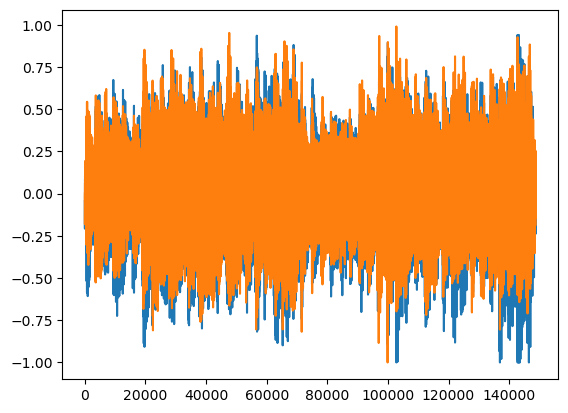

In [10]:
x = x / np.max(np.abs(x))
plt.figure()
plt.plot(x)
plt.plot(y)